In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics

In [2]:
from pathlib import Path
log_dir = Path('logs/')

In [3]:
from torch.utils.data import Dataset, DataLoader

class ModulatorDataset(Dataset):
    def __init__(self, bit_count):
        super().__init__()
        self.bit_count = bit_count
        
    def __len__(self):
        return 2 ** self.bit_count
    
    def __getitem__(self, idx):
        result = torch.zeros(2 ** self.bit_count)
        result[idx] = 1
        return result

bit_count = 4
class_count = 2 ** bit_count
dataset = ModulatorDataset(bit_count)
dataloader = DataLoader(dataset, batch_size=class_count, shuffle=True)

In [4]:
class EntropyNormalization(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        energy = (x ** 2).sum(axis=1).mean()
        return x / energy.sqrt()

class AwgnNoise(pl.LightningModule):
    def __init__(self, snr):
        super().__init__()
        self.sigma = np.sqrt(1 / (2 * 10 ** (snr / 10)))
        
    def forward(self, x):
        return x + torch.normal(torch.zeros_like(x, device=self.device), 
                                torch.full_like(x, self.sigma, device=self.device))
    
class ModulatorAutoencoder(pl.LightningModule):
    def __init__(self, class_count, encoding_shape, snr):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(class_count, 4 * class_count),
            nn.ReLU(),
            nn.Linear(4 * class_count, encoding_shape),
            EntropyNormalization()
        )
        self.noise = AwgnNoise(snr)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_shape, 4 * class_count),
            nn.ReLU(),
            nn.Linear(4 * class_count, class_count)
        )
        self.loss_function = nn.CrossEntropyLoss()
        self.symbol_error_rate = torchmetrics.Accuracy()
        
    def forward(self, x):
        encoded = self.encoder(x)
        noised = self.noise(encoded)
        return self.decoder(noised)
    
    def measure_error(self, dataloader, repeat=1000):
        correct = 0
        total = 0
        for _ in range(repeat):
            for batch in dataloader:
                decoded = self(batch)
                prediction = decoded.argmax(-1)
                true_classes = batch.argmax(-1)
                
                correct += (prediction == true_classes).detach().cpu().sum().item()
                total += batch.shape[0]
        return 1 - correct / total
    
    def training_step(self, batch, batch_idx):
        decoded = self(batch)
        prediction = decoded.argmax(-1)
        true_classes = batch.argmax(-1)
        loss = self.loss_function(decoded, batch)
        ser = self.symbol_error_rate(prediction, true_classes)
        self.log('ser', ser, on_epoch=True, on_step=False, prog_bar=True)
        self.log('loss', loss, on_epoch=True, on_step=False)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.005)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=1000, threshold=0.005, min_lr=1e-5)
        return {
            'optimizer': optimizer
        }

In [5]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.progress import ProgressBar
import tqdm


def train_models(bit_count, snrs, device_id=0, root_path=Path('model_storage')):
    class_count = 2 ** bit_count
    dataset = ModulatorDataset(bit_count)
    dataloader = DataLoader(dataset, batch_size=class_count, shuffle=True, pin_memory=True)
    
    for snr in snrs:
        model = ModulatorAutoencoder(class_count, 2, snr)
        logger = CSVLogger(save_dir=log_dir)
        device = torch.device(f'cuda:{device_id}')
        trainer = pl.Trainer(max_epochs=20000, logger=logger, gpus=[device_id])
        trainer.fit(model, train_dataloaders=dataloader)
        
        filename = f'ae_{class_count}_{snr}.pt'
        path = root_path / filename
        torch.save(model.state_dict(), path)
        
train_models(6, [18, 19, 20, 21, 22, 23, 24])
# train_models(6, [40])
# train_models(4, [13, 14, 15, 16, 17])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 17.2 K
1 | noise             | AwgnNoise        | 0     
2 | decoder           | Sequential       | 17.2 K
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params
0.137     Total estimated model params size (MB)
/home/drbelikov/anaconda3/envs/modulation/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which

Training: 0it [00:00, ?it/s]

/home/drbelikov/anaconda3/envs/modulation/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 17.2 K
1 | noise             | AwgnNoise        | 0     
2 | decoder           | Sequential       | 17.2 K
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params
0.137     Total estimated model params size 

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 17.2 K
1 | noise             | AwgnNoise        | 0     
2 | decoder           | Sequential       | 17.2 K
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params
0.137     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 17.2 K
1 | noise             | AwgnNoise        | 0     
2 | decoder           | Sequential       | 17.2 K
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params
0.137     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 17.2 K
1 | noise             | AwgnNoise        | 0     
2 | decoder           | Sequential       | 17.2 K
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params
0.137     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 17.2 K
1 | noise             | AwgnNoise        | 0     
2 | decoder           | Sequential       | 17.2 K
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params
0.137     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder           | Sequential       | 17.2 K
1 | noise             | AwgnNoise        | 0     
2 | decoder           | Sequential       | 17.2 K
3 | loss_function     | CrossEntropyLoss | 0     
4 | symbol_error_rate | Accuracy         | 0     
-------------------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params
0.137     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [51]:
ls

Baseline64.ipynb     __init__.py  model_storage/
Baseline.ipynb       logs/        quality.ipynb
ClippingNoise.ipynb  LSTM.ipynb   TestDropout.ipynb


In [ ]:
bit_count = 6
class_count = 2 ** bit_count
dataset = ModulatorDataset(bit_count)
dataloader = DataLoader(dataset, batch_size=class_count, shuffle=True)

# class_count = 64
loaded = ModulatorAutoencoder(class_count, 2, 25)
loaded.load_state_dict(torch.load(Path('model_storage/ae_64_20.pt')))
loaded.eval()
# loaded = model
# loaded.eval()
device_id = 0
device = torch.device(f'cuda:{device_id}')
loaded = loaded.to(device)
outputs = []
for batch in dataloader:
    cur_outputs = loaded.encoder(batch.to(device))
    outputs.append(cur_outputs.cpu().detach().numpy())
points = np.concatenate(outputs)
plt.gca().set_aspect('equal', adjustable='box')
for point in points:
    plt.scatter(x=point[0], y=point[1], c='red')

In [13]:
torch.cuda.empty_cache()

In [20]:
predictions = []
labels = []

model.eval()
for _ in range(100000):
    for batch in dataloader:
        encoded = model.to(device).encoder(batch.to(device))
        noise = torch.normal(torch.zeros(encoded.shape, device=device), 
                             torch.ones(encoded.shape, device=device) / 10)
        noised = encoded + noise
        decoded = model.to(device).decoder(noised)
        cur_prediction = decoded.cpu().detach().argmax(-1).numpy()
        cur_labels = batch.argmax(-1).numpy()
        labels.append(cur_labels)
        predictions.append(cur_prediction)

true_labels = np.concatenate(labels)
model_predictions = np.concatenate(predictions)

error_count = (true_labels != model_predictions).sum()
ser = error_count / len(true_labels)
ser

0.003626875

In [14]:
2

2

In [ ]:
## 1 - (1 - 2Q(sqrt(3E/N_0 * 1 / (q - 1)))) ^ 2
## Q(x) = erfc(x / sqrt(2)) / 2
## erfc(x) = 1 - erf(x)
## erf(x) = 2 / sqrt(pi) * int_0^x e^(-z^2)dz

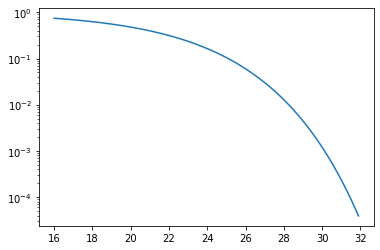

In [10]:
from scipy.special import erfc

def Q(x):
    return erfc(x / np.sqrt(2)) / 2

def p_error(snr, q=16):
    sigma = 1 / 2 / (10 ** (snr / 10))
    n0 = 2 * sigma
    return 1 - (1 - 2 * Q(np.sqrt(3 / n0 / (q - 1)))) ** 2

def p_stupid(snr, q=16):
    sigma = 1 / 2 / (10 ** (snr / 10))
    n0 = 2 * sigma
    return np.exp(-3 / 2 / (q - 1) / n0)

snrs = np.arange(16, 32, 0.1)
plt.yscale('log')
# for q in [4, 16, 64]:
for q in [256]:
    ys = [p_error(snr, q) for snr in snrs]
    # zs = [p_stupid(snr, q) for snr in snrs]
    plt.plot(snrs, ys)
    # plt.plot(snrs, zs)


# bit_count = 6
# class_count = 2 ** bit_count
# nn_probs = []
# nn_snrs = [18, 19, 20, 21, 22, 23, 24]
# for snr in nn_snrs:
#     loaded = ModulatorAutoencoder(class_count, 2, snr)
#     loaded.load_state_dict(torch.load(Path(f'model_storage/ae_{class_count}_{snr}.pt')))
#     loaded.eval()
    
#     dataset = ModulatorDataset(bit_count)
#     dataloader = DataLoader(dataset, batch_size=class_count, shuffle=True, pin_memory=True)
    
#     correct = 0
#     total = 0
#     for _ in range(10 ** 3):
#         for batch in dataloader:
#             prediction = loaded(batch).cpu().detach().argmax(-1)
#             true_labels = batch.argmax(-1)
#             correct += (true_labels == prediction).sum().item()
#             total += class_count
#     nn_probs.append(1 - correct / total)
    
# plt.scatter(nn_snrs, nn_probs, s=10, c='green');

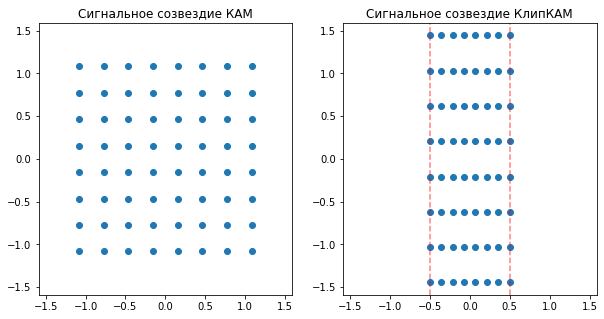

In [29]:
from ml_modulation.modulators.qam import QAM
from ml_modulation.modulators.clipped_qam import ClippedQAM

bit_count = 6
QAM16 = QAM(bit_count)
clipped = ClippedQAM(bit_count, 0.5)

xs = []
ys = []

clip_xs = []
clip_ys = []

for class_idx in range(2 ** bit_count):
    bits = []
    while len(bits) < bit_count:
        bit = class_idx % 2
        bits.append(bit)
        class_idx //= 2
    x, y = QAM16.encode(bits)[0]
    clip_x, clip_y = clipped.encode(bits)[0]
    xs.append(x)
    ys.append(y)
    clip_xs.append(clip_x)
    clip_ys.append(clip_y)

figure, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.scatter(xs, ys)
ax1.scatter(clip_xs, clip_ys)

x_limits = list(ax0.get_xlim())
y_limits = list(ax0.get_ylim())
x_limits1 = list(ax1.get_xlim())
y_limits1 = list(ax1.get_ylim())

max_limit = max([max(abs(x), abs(y))for x, y in [x_limits, y_limits, x_limits1, y_limits1]])

# x_limits[0] = min(x_limits[0], x_limits1[0])
# x_limits[1] = max(x_limits[1], x_limits1[1])

# y_limits[0] = min(y_limits[0], y_limits1[0])
# y_limits[1] = max(y_limits[1], y_limits1[1])

# ax0.set_xlim(x_limits)
# ax0.set_ylim(y_limits)

# ax1.set_xlim(x_limits)
# ax1.set_ylim(y_limits);

ax0.set_title('Сигнальное созвездие КАМ')
ax1.set_title('Сигнальное созвездие КлипКАМ')

ax0.set_xlim((-max_limit, max_limit))
ax0.set_ylim((-max_limit, max_limit))


ax1.axvline(x=0.5, c='r', alpha=0.5, ls='--')
ax1.axvline(x=-0.5, c='r', alpha=0.5, ls='--')
ax1.set_xlim((-max_limit, max_limit))
ax1.set_ylim((-max_limit, max_limit));

# figure.savefig('../images/clip_qam.png', facecolor='white')

(-1.0435516278555652, 1.0435516278555652)

In [44]:
import os
import sys

directory = '~/ml-modulation/ml_modulation/modulators/qam'
sys.path.append(directory)

In [45]:
print(sys.path)

['/home/drbelikov/ml-modulation/notebooks', '/home/drbelikov/anaconda3/envs/modulation/lib/python39.zip', '/home/drbelikov/anaconda3/envs/modulation/lib/python3.9', '/home/drbelikov/anaconda3/envs/modulation/lib/python3.9/lib-dynload', '', '/home/drbelikov/anaconda3/envs/modulation/lib/python3.9/site-packages', '~/ml-modulation', '~/ml-modulation', '~/ml-modulation', '~/ml-modulation/ml_modulation', '~/ml-modulation/ml_modulation/modulators', '~/ml-modulation/ml_modulation/modulators/qam']
